# Transatlantic Survival pipeline using Supervised Machine Learning

## Abstract

The sinking of the titanic is a well known incident, adapted into a very popular movie which is frequently referenced by pop-culture. The following analysis focuses on attempting to predict whether a given passenger would survive or not based on certain information and finding the best machine learning model to achieve this task while providing insight into which set of "characteristics" would most likely determine the survival of passengers. The task focused on testing different machine learning models to see which performed best. During the task the best performing machine learning model was Logistic Regression, however Multinomial Naive Bayes was selected for its lower variability . The analysis also indicated that the passenger's class, sex and number of languages, in the order mentioned, were most likely to determine survival, which  supports the idea that richer passengers and passengers who were female were most likely to survive. Having finished the task it would be interesting to try with more complex models that did not assume independence between features, specially since that is one of the main drawbacks of the chosen model, Multinomial Naive bayes.  

## Importing Packages

In [72]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB, BernoulliNB, ComplementNB
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # sklearn.cross_validation in old versions
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import re, itertools
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## EDA

In [73]:
df = pd.read_csv('titanic.csv')  #github repo under data directory for HW6
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,BaggageWeight,BodyWeight,Languages,MealPlan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,58.0,20.0,4,level2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,211.0,57.0,5,level4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,76.0,105.0,2,level2


In [74]:
print("Missing values per column per faature")
isna_vals = df.isna().sum()
df_isnas = pd.DataFrame(isna_vals,isna_vals.index)
display(df_isnas.T)

print("\n Unique Values per feature")
unique_values = df.nunique()
df_uniques = pd.DataFrame(unique_values, unique_values.index)
display(df_uniques.T)
print("\n DataFrame Description")
df.describe()

Missing values per column per faature


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,BaggageWeight,BodyWeight,Languages,MealPlan
0,0,0,0,0,0,177,0,0,0,0,687,2,0,177,0,0



 Unique Values per feature


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,BaggageWeight,BodyWeight,Languages,MealPlan
0,891,2,3,891,2,88,7,7,681,248,147,3,193,191,5,4



 DataFrame Description


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,BaggageWeight,BodyWeight,Languages
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,81.552189,72.501401,3.021324
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,56.691223,57.286961,1.399275
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,47.000000,27.250000,2.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,75.000000,61.500000,3.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,100.000000,102.000000,4.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,612.000000,341.000000,5.000000


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  BaggageWeight  891 non-null    float64
 13  BodyWeight     714 non-null    float64
 14  Languages      891 non-null    int64  
 15  MealPlan       891 non-null    object 
dtypes: float64(4), int64(6), object(6)
memory usage: 111.5+ KB


In [76]:
# A bit of feature engineering since Parch is quite imbalanced
print("Value Counts Parch", list(df["Parch"].value_counts()))
df["Children"] = np.where(df["Parch"]==0,0,1)

Value Counts Parch [678, 118, 80, 5, 5, 4, 1]


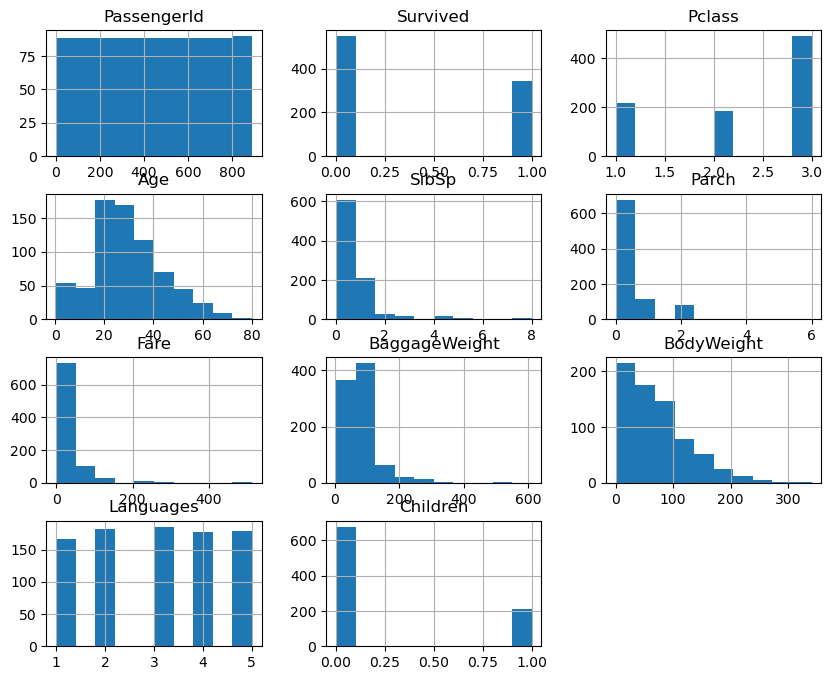

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'MealPlan']


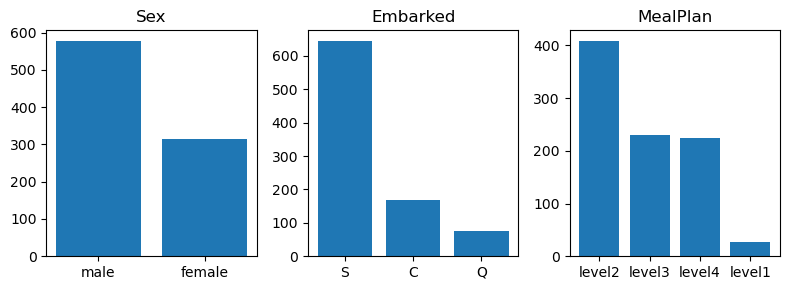

In [77]:
# Visualize feature distribution
df.hist(bins=10, figsize=(10, 8))
plt.show()

fig,axs = plt.subplots(1,3,figsize=(8,3))
discrete_data = df.select_dtypes(include=['object']).columns.tolist()
print(discrete_data)
j= 0
for i,col in enumerate(discrete_data):
    if df[col].nunique()<=4:
        
        counts = df[col].value_counts()
        axs[j].set_title(col)
        axs[j].bar(counts.index,counts.values)
        j+=1
plt.tight_layout()
plt.show()

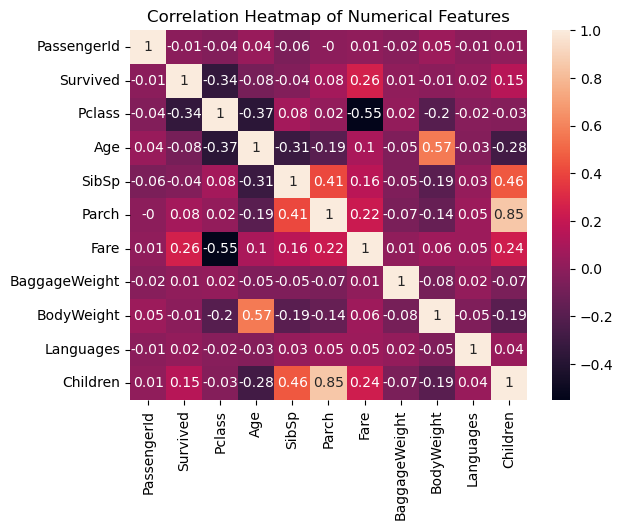

In [78]:
# Correlation of continuous features 
discrete_data = df.select_dtypes(include=['int64','float64']).columns.tolist()
explore =df[discrete_data].copy()
corr_matrix = explore.corr().round(2)   
sns.heatmap(data=corr_matrix, annot=True)   
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Preprocessing

In [79]:
# Drop unsuable feautures
df = df.drop(["Name"], axis=1, inplace=False, errors='ignore')
df= df.drop(["PassengerId"], axis=1, inplace=False, errors='ignore')
df= df.drop(["Cabin"], axis=1, inplace=False, errors='ignore')
df= df.drop(["Ticket"], axis=1, inplace=False, errors='ignore')

# There is only 1 categorized as 6 in parch
df = df[df["Parch"] != 6]

# Making it easier to select categorical values
df["Pclass"] = df["Pclass"].astype('str')
df["Sex"] = df["Sex"].astype('str')
df["Embarked"] = df["Embarked"].astype('str')
df["Languages"] = df["Languages"].astype('str')
df["MealPlan"] = df["MealPlan"].astype('str')
df["Children"] = df["Children"].astype('str')
df["Parch"] = df["Parch"].astype('str')
# df["SibSp"] = df["SibSp"].astype('str')
 

In [80]:
# select target variables
y = df['Survived'].astype('str')
df= df.drop(["Survived"], axis=1, inplace=False, errors='ignore')

In [81]:
# chosen features
chosen_features = ["Pclass","Sex", "Embarked","Languages","SibSp", "Age", "Fare", "BodyWeight"] 

# Continuous
categorical_features = ["Pclass","Sex", "Embarked","Languages",]
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Discrete
numerical_features = ["Age", "Fare", "BodyWeight","SibSp"]
numerical_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()

In [82]:
X = df[chosen_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipelines and Hyperparameter-tunning

In [83]:
# Machine Learning Algorithms to compare
estimators = [  {'clf': [BernoulliNB()]},
                {'clf': [ComplementNB()]},
                {'clf': [MultinomialNB()]},
                {'clf': [LogisticRegression()]},
                {'clf': [DecisionTreeClassifier()]},
                {'clf': [KNeighborsClassifier()]},
                {'clf': [GaussianNB()]}]

 
num_pipeline = Pipeline([ 
    ('fillna', SimpleImputer(strategy="median")),
    ('scale', MinMaxScaler()),
])

cat_pipeline = Pipeline([
    ('input',SimpleImputer(strategy="constant")),
    ('one_hot', OneHotEncoder()),
    ])

 
data_pipeline = ColumnTransformer(transformers= [
        # (name, transformer,     columns)
        ('num',num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
])

 
survival_pipeline = Pipeline([
        ("preparation", data_pipeline), 
        ('clf', None)
])  

 
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

In [84]:
grid_search = GridSearchCV(survival_pipeline, param_grid=estimators,cv=5, n_jobs=-1, scoring=scoring, refit='accuracy',)
t0 = time()
grid_search.fit(X_train,y_train)
 

best_parameters = grid_search.best_estimator_.get_params()
print(f"Best model is {grid_search.best_params_}")
mean_accuracy = grid_search.best_score_
print(f"Mean accuracy of best model: {mean_accuracy:.4f}")
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_box = results_df.copy().T

# Show Results of Analysos
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print(f"test_acc on heldout test set by best pipeline is: {accuracy_score(y_pred, y_test):.3f}")
untouched_results_df= results_df.copy()
results_df[["mean_score_time","param_clf", "mean_test_precision_macro","std_test_precision_macro","mean_test_accuracy","std_test_accuracy","mean_test_recall_macro","std_test_recall_macro",]].set_index('param_clf')
 

Best model is {'clf': KNeighborsClassifier()}
Mean accuracy of best model: 0.7978
test_acc on heldout test set by best pipeline is: 0.787


,mean_score_time,mean_test_precision_macro,std_test_precision_macro,mean_test_accuracy,std_test_accuracy,mean_test_recall_macro,std_test_recall_macro
param_clf,,,,,,,
BernoulliNB(),0.004504,0.758525,0.026664,0.772481,0.028623,0.762089,0.035143
ComplementNB(),0.004190,0.746337,0.029988,0.758436,0.028517,0.756919,0.035558
MultinomialNB(),0.003872,0.768268,0.019993,0.778085,0.019739,0.751685,0.019398
LogisticRegression(),0.004021,0.789481,0.017215,0.794947,0.017405,0.770910,0.029071
DecisionTreeClassifier(),0.003625,0.720490,0.051377,0.735901,0.051708,0.723570,0.050011
KNeighborsClassifier(),0.012455,0.789043,0.025952,0.797784,0.026130,0.773084,0.034996
GaussianNB(),0.003258,0.739806,0.038328,0.672777,0.032949,0.572270,0.024400


In [85]:
# Review feature Importance
init_cols = [""]
model_fi = permutation_importance(best_pipeline, X, y)
imp_df = pd.DataFrame(model_fi['importances_mean'].reshape(1,8),columns= chosen_features)
imp_df

,Pclass,Sex,Embarked,Languages,SibSp,Age,Fare,BodyWeight
0,0.072135,0.190562,0.02427,0.033483,0.004045,0.00382,-0.002022,0.0


In [86]:
# Drop feautures with negative impact on target
chosen_features = ['Pclass', 'Sex', 'Embarked', 'Languages', 'SibSp', 'Age', 'Fare']
X = df[chosen_features].copy()

numerical_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

data_pipeline = ColumnTransformer(transformers= [
        # (name, transformer,     columns)
        ('num',num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
])

survival_pipeline = Pipeline([
        ("preparation", data_pipeline),# combination of numerical, categorical subpipelines
        ('clf', LogisticRegression())])  # classifier estimator you are using
    

# Extrinsic metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_pipeline = grid_search.best_estimator_
survival_pipeline.fit(X_train,y_train)
y_pred = survival_pipeline.predict(X_test)
 
print(f"\nTest accuracy with best pipeline is: {accuracy_score(y_pred, y_test):.3f}")
print(f"Test recall with best pipeline is: {recall_score(y_test, y_pred, pos_label='1', average='binary'):.3f}")
print(f"Test precision with best pipeline is: {precision_score(y_test, y_pred, pos_label='1', average='binary'):.3f}")



Test accuracy with best pipeline is: 0.843
Test recall with best pipeline is: 0.797
Test precision with best pipeline is: 0.819


In [87]:
results_df['param_clf'] = results_df['param_clf'].astype(str)
grouped_results_mean = results_df[['param_clf','mean_test_accuracy', 'mean_test_precision_macro','mean_test_recall_macro']] #.reset_index()
grouped_results_mean = grouped_results_mean.set_index('param_clf')

In [88]:
results_df['param_clf'] = results_df['param_clf'].astype(str)
grouped_results_mean = results_df[['param_clf','mean_test_accuracy', 'mean_test_precision_macro','mean_test_recall_macro']] #.reset_index()
grouped_results_mean = grouped_results_mean.set_index('param_clf')

/var/folders/vp/rh6t6tmd1sl23sgs8jp4g7r80000gn/T/ipykernel_9385/2209824559.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped_results_mean.index, rotation=90)


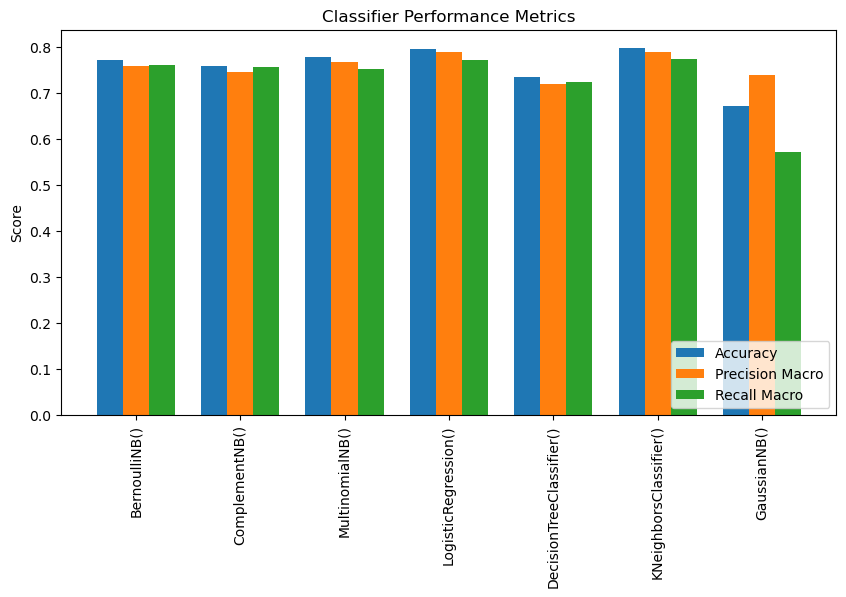

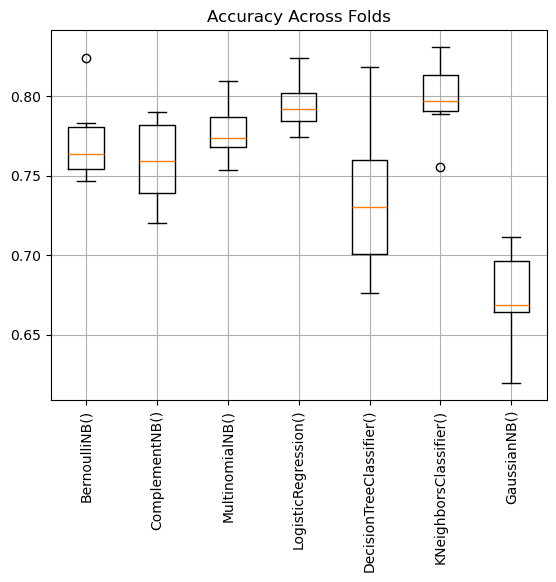

In [89]:
fig, ax = plt.subplots(figsize=(10,5))
bars1 = ax.bar(np.arange(len(grouped_results_mean)) - 0.25, grouped_results_mean["mean_test_accuracy"], 0.25, label='Accuracy')
bars2 = ax.bar(np.arange(len(grouped_results_mean)), grouped_results_mean["mean_test_precision_macro"], 0.25, label='Precision Macro')
bars2 = ax.bar(np.arange(len(grouped_results_mean))+0.25, grouped_results_mean["mean_test_recall_macro"], 0.25, label='Recall Macro')
ax.set_xticklabels(grouped_results_mean.index, rotation=90)
ax.set_ylabel('Score')
ax.set_title('Classifier Performance Metrics')
ax.set_xticks(np.arange(len(grouped_results_mean)))
ax.legend(loc='lower right')
plt.show()
splits_accuracy = results_df.T.loc[["split0_test_accuracy","split1_test_accuracy","split2_test_accuracy","split3_test_accuracy","split4_test_accuracy","mean_test_accuracy"]]
splits_accuracy.columns = results_df.T.loc["param_clf"]
plt.boxplot(splits_accuracy)
plt.title("Accuracy Across Folds")
ax = plt.gca()   
ax.set_xticklabels(splits_accuracy.columns,rotation=90)
 
plt.grid()
plt.show()

## Discussion

Most models yielded similar results; however there were a few outliers such as the decision Tree and Gaussian Naive Bayes models, which had high variability in results and performed the poorest respectively. The best performing model was KNeighborsClassifier with its highest accuracy across folds being 0.83, and its mean accuracy 0.797 during the first test, followed by Multinomial Naive Bayes which reached a mean accuracy of 0.794 during the first test. Most models took almost the same amount computing the results, with the exception of KNN which took more than twice as the others.

KNN's biggest disadvantage is the duration of the algoritm's computations, which is bound to grow exponentially if we increase the data size. At the same time it is likely the model could have overfitted since even though it has a large k our dataset is quite small at 891 instances. The best metric for KNN was accuracy, and the lowest was recall which gives insights into the passengers misclassified as non-survivors. The next best highest score was achieve by a Naive Bayes Algorithm but it was an outlier and may have just been a fold that benefited the model. The next best mean score was achieved by Logistic Regression, which took much less computing time and still had a high accuracy at 0.794. Logistic Regression is calculated using SDG and only stores the the weights defining the hyperplane is comparison the KNN which stores the whole dataset. Which is why the chosen model is LogisticRegression.

Chosen model: Logistic Regression